In [ ]:
# 標準搭載ライブラリ
import os
import warnings

# 今回の主題
import tensorflow as tf
import tensorflow_probability as tfp

# データ前処理・後処理用
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.model_selection

# 描画系
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


In [ ]:
print(tf.__version__)
print(tfp.__version__)
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)

2.8.2
0.16.0
1.21.6
1.3.5
3.2.2
1.0.2


# california_housingを用いた回帰タスク

In [ ]:
california_housing = sklearn.datasets.fetch_california_housing()

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(california_housing.data, california_housing.target)

# NNを安定的に学習させるため、標準化を行う
standard_scaler = sklearn.preprocessing.StandardScaler()
standard_scaler.fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

# 予測対象が正のみで、緩やかな対数正規分布のため、logをとる
y_train = np.log(y_train)
y_test = np.log(y_test)

## 比較対象として古典的線形回帰を行う

In [ ]:
frequentism_model = tf.keras.models.Sequential([                                
  tf.keras.layers.Dense(1, activation="linear"),
])

frequentism_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error',
)

In [ ]:
frequentism_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
484/484 [==============================] - 1s 2ms/step - loss: 1.0384 - val_loss: 0.1572
Epoch 2/20
484/484 [==============================] - 1s 2ms/step - loss: 0.6326 - val_loss: 0.1441
Epoch 3/20
484/484 [==============================] - 1s 2ms/step - loss: 0.3444 - val_loss: 0.1270
Epoch 4/20
484/484 [==============================] - 1s 2ms/step - loss: 0.2197 - val_loss: 0.1577
Epoch 5/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1580 - val_loss: 0.1241
Epoch 6/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1401 - val_loss: 0.1218
Epoch 7/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1317 - val_loss: 0.1250
Epoch 8/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1332 - val_loss: 0.1258
Epoch 9/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1309 - val_loss: 0.1243
Epoch 10/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1329 - val_loss: 0.1214

In [ ]:
pd.DataFrame({"feature": california_housing.feature_names, "weight": frequentism_model.layers[0].weights[0].numpy().flatten()})

,feature,weight
0,MedInc,0.335726
1,HouseAge,0.030790
2,AveRooms,-0.101043
3,AveBedrms,0.112357
4,Population,0.026236
5,AveOccup,-0.022024
6,Latitude,-0.614321
7,Longitude,-0.546516


## ベイズ線形回帰

In [ ]:
kld = (lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(len(y_train), dtype=tf.float32))

bayesian_model = tf.keras.models.Sequential([
  tfp.layers.DenseFlipout(
      1, kernel_divergence_fn=kld,
      activation="linear"),
])

bayesian_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error',
)

In [ ]:
bayesian_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


484/484 [==============================] - 2s 3ms/step - loss: 0.3008 - val_loss: 0.1405
Epoch 2/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1493 - val_loss: 0.1296
Epoch 3/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1358 - val_loss: 0.1930
Epoch 4/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1388 - val_loss: 0.1587
Epoch 5/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1357 - val_loss: 0.1347
Epoch 6/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1394 - val_loss: 0.1277
Epoch 7/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1339 - val_loss: 0.1251
Epoch 8/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1475 - val_loss: 0.1243
Epoch 9/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1463 - val_loss: 0.1325
Epoch 10/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1340 - val_loss: 0.1264
Epoch 11/2

In [ ]:
pd.DataFrame({
    "feature": california_housing.feature_names, 
    "weight_loc": bayesian_model.layers[0].weights[0].numpy().flatten(),
    "weight_scale": tf.nn.softplus(bayesian_model.layers[0].weights[1]).numpy().flatten(),
})

,feature,weight_loc,weight_scale
0,MedInc,0.384468,0.004109
1,HouseAge,0.020860,0.005366
2,AveRooms,-0.054771,0.006625
3,AveBedrms,0.104812,0.011414
4,Population,0.031864,0.004288
5,AveOccup,-0.035195,0.015467
6,Latitude,-0.568704,0.006398
7,Longitude,-0.558844,0.005438


## ベイズ深層学習

In [ ]:
kld = (lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(len(y_train), dtype=tf.float32))

bayesian_deep_model = tf.keras.models.Sequential([
  tfp.layers.DenseFlipout(
      8, kernel_divergence_fn=kld,
      activation="sigmoid"),
  tfp.layers.DenseFlipout(
      8, kernel_divergence_fn=kld,
      activation="sigmoid"),
  tfp.layers.DenseFlipout(
      1, kernel_divergence_fn=kld,
      activation="linear"),
])

bayesian_deep_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error',
)

In [ ]:
bayesian_deep_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


484/484 [==============================] - 3s 3ms/step - loss: 0.1722 - val_loss: 0.1185
Epoch 2/20
484/484 [==============================] - 1s 3ms/step - loss: 0.1197 - val_loss: 0.1194
Epoch 3/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1163 - val_loss: 0.1133
Epoch 4/20
484/484 [==============================] - 1s 3ms/step - loss: 0.1148 - val_loss: 0.1107
Epoch 5/20
484/484 [==============================] - 1s 3ms/step - loss: 0.1139 - val_loss: 0.1112
Epoch 6/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1124 - val_loss: 0.1142
Epoch 7/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1107 - val_loss: 0.1088
Epoch 8/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1110 - val_loss: 0.1124
Epoch 9/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1090 - val_loss: 0.1058
Epoch 10/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1097 - val_loss: 0.1072
Epoch 11/2

In [ ]:
df_test = pd.DataFrame(X_test, columns=california_housing.feature_names)

preds = tf.stack([bayesian_deep_model.predict(df_test) for _ in range(100)])
df_test["BayesPred"] = tf.keras.backend.mean(preds,axis=0).numpy().flatten()
df_test["BayesPredStd"] = tf.keras.backend.std(preds,axis=0).numpy().flatten()

In [ ]:
# ベイズ予測分布の分散が大きいデータ群
df_test.sort_values("BayesPredStd", ascending=False).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,BayesPred,BayesPredStd
2323,-1.289310,-0.052337,11.292170,16.538456,-1.201846,-0.089528,0.039657,0.490325,0.567012,0.334870
3593,-0.775626,-0.687702,5.889500,9.308203,-0.690936,-0.036960,0.086534,0.435511,0.240695,0.333255
1160,-1.049412,0.344767,60.103694,54.816581,-1.263885,-0.031612,1.535026,-0.262128,0.389401,0.323805
1341,-0.653539,-0.290599,23.979814,31.755788,-1.265709,-0.114166,2.172550,-0.835189,0.495834,0.305712
2062,1.199621,-1.164227,7.664122,11.742492,-1.259323,-0.088079,2.102235,-1.099295,0.782315,0.284727


In [ ]:
# ベイズ予測分布の分散が小さいデータ群
df_test.sort_values("BayesPredStd", ascending=True).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,BayesPred,BayesPredStd
3029,-0.341644,-0.449440,0.069544,-0.049352,-0.327826,0.001922,0.358419,0.236185,-0.038746,0.020048
3014,-0.226630,-0.052337,-0.092572,0.091100,0.208629,-0.018355,-0.283792,0.943791,-0.030300,0.022416
4927,-0.407517,-0.131757,0.048225,-0.077410,-0.098829,-0.019874,0.808436,-0.511285,0.039061,0.023224
2352,-0.139432,-0.846544,0.127225,-0.006147,0.021600,-0.015428,-0.888502,0.799280,0.528984,0.023378
3646,-0.349033,-0.767123,-0.051890,-0.313750,0.232350,0.010342,0.419359,0.006961,0.030648,0.023903


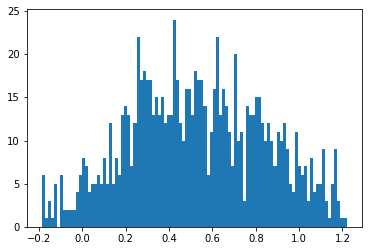

In [ ]:

preds = bayesian_deep_model.predict(pd.DataFrame([df_test[california_housing.feature_names].iloc[df_test["BayesPredStd"].idxmax()]]*1000)).flatten()
preds_mean = preds.mean()
preds_std = preds.std()

plt.hist(preds, bins=100, range=(preds.mean() - 2 * preds_std, preds.mean() + 2* preds_std))
plt.show()

# mnist

参考: https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/bayesian_neural_network.py

In [6]:


IMAGE_SHAPE = [28, 28, 1]
NUM_TRAIN_EXAMPLES = 60000

num_epochs=10
batch_size=128
FIG_DIR="/tmp/bayesian_neural_network/"
num_monte_carlo=50



In [ ]:
os.mkdir(FIG_DIR)
matplotlib.use('Agg')
warnings.simplefilter(action='ignore')

## 可視化部分
- 重要ではないのと参考ソースをほぼ丸々流用しているので、本編では触れない

In [ ]:

def plot_weight_posteriors(names, qm_vals, qs_vals, fname):
  
  fig = matplotlib.figure.Figure(figsize=(6, 3))
  canvas = matplotlib.backend.backend_agg.FigureCanvasAgg(fig)

  ax = fig.add_subplot(1, 2, 1)
  for n, qm in zip(names, qm_vals):
    sns.distplot(qm.reshape([-1]), ax=ax, label=n)
  ax.set_title('weight means')
  ax.set_xlim([-1.5, 1.5])
  ax.legend()

  ax = fig.add_subplot(1, 2, 2)
  for n, qs in zip(names, qs_vals):
    sns.distplot(qs.reshape([-1]), ax=ax)
  ax.set_title('weight stddevs')
  ax.set_xlim([0, 1.])

  fig.tight_layout()
  canvas.print_figure(fname, format='png')
  print('saved {}'.format(fname))


def plot_heldout_prediction(input_vals, probs,
                            fname, n=10, title=''):
  
  fig = matplotlib.figure.Figure(figsize=(9, 3*n))
  canvas = matplotlib.backend.backend_agg.FigureCanvasAgg(fig)
  for i in range(n):
    ax = fig.add_subplot(n, 3, 3*i + 1)
    ax.imshow(input_vals[i, :].reshape(IMAGE_SHAPE[:-1]), interpolation='None')

    ax = fig.add_subplot(n, 3, 3*i + 2)
    for prob_sample in probs:
      sns.barplot(np.arange(10), prob_sample[i, :], alpha=0.1, ax=ax)
      ax.set_ylim([0, 1])
    ax.set_title('posterior samples')

    ax = fig.add_subplot(n, 3, 3*i + 3)
    sns.barplot(np.arange(10), np.mean(probs[:, i, :], axis=0), ax=ax)
    ax.set_ylim([0, 1])
    ax.set_title('predictive probs')
  fig.suptitle(title)
  fig.tight_layout()

  canvas.print_figure(fname, format='png')
  print('saved {}'.format(fname))



In [ ]:


def create_model(num_train_examples: int, num_classes: int):

  # ここのnum_train_examplesって必要なんか？
  kl_divergence_function = (lambda q, p, _: tfp.distributions.kl_divergence(q, p) / 
                            tf.cast(num_train_examples, dtype=tf.float32))

  model = tf.keras.models.Sequential([
      tfp.layers.Convolution2DFlipout(
          6, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tfp.layers.Convolution2DFlipout(
          16, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tfp.layers.Convolution2DFlipout(
          120, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.Flatten(),
      tfp.layers.DenseFlipout(
          84, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tfp.layers.DenseFlipout(
          num_classes, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.softmax)
  ])

  # Model compilation.
  optimizer = tf.keras.optimizers.Adam(lr=0.001)
  # We use the categorical_crossentropy loss since the MNIST dataset contains
  # ten labels. The Keras API will then automatically add the
  # Kullback-Leibler divergence (contained on the individual layers of
  # the model), to the cross entropy loss, effectively
  # calcuating the (negated) Evidence Lower Bound Loss (ELBO)
  model.compile(optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'], experimental_run_tf_function=False)
  return model



In [ ]:

import random

train_set, heldout_set = tf.keras.datasets.mnist.load_data()

def normalize_image(images):
  return (2*(images / 255.) - 1)

sampling_rate=0.1
train_datasize = int(50000 * sampling_rate)

sampling_set = [(X,y) for (X, y) in zip(*train_set) if (random.random()<=sampling_rate)]
train_set = (np.stack([tpl[0] for tpl in sampling_set]), np.stack([tpl[1] for tpl in sampling_set]))

X_train, y_train = normalize_image(train_set[0][:train_datasize]), tf.keras.utils.to_categorical(train_set[1][:train_datasize])
X_valid, y_valid = normalize_image(train_set[0][train_datasize:]), tf.keras.utils.to_categorical(train_set[1][train_datasize:])
X_test, y_test = normalize_image(heldout_set[0]), tf.keras.utils.to_categorical(heldout_set[1])


In [ ]:
model = create_model(X_train.shape[0])
# TODO(b/149259388): understand why Keras does not automatically build the
# model correctly.
model.build(input_shape=[None, 28, 28, 1])

model.fit(
    x=X_train, 
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size = batch_size,
    epochs=5
)

Epoch 1/5
40/40 [==============================] - 17s 352ms/step - loss: 276.7087 - accuracy: 0.2002 - val_loss: 274.1754 - val_accuracy: 0.3240
Epoch 2/5
40/40 [==============================] - 12s 308ms/step - loss: 271.8330 - accuracy: 0.5066 - val_loss: 269.2464 - val_accuracy: 0.6856
Epoch 3/5
40/40 [==============================] - 12s 307ms/step - loss: 267.2407 - accuracy: 0.7290 - val_loss: 264.9365 - val_accuracy: 0.8077
Epoch 4/5
40/40 [==============================] - 13s 315ms/step - loss: 263.0060 - accuracy: 0.8374 - val_loss: 260.8490 - val_accuracy: 0.8462
Epoch 5/5
40/40 [==============================] - 12s 309ms/step - loss: 258.9380 - accuracy: 0.8700 - val_loss: 256.8301 - val_accuracy: 0.8788


In [ ]:


probs = tf.stack([model.predict(X_test[:10], verbose=1)
                  for _ in range(num_monte_carlo)], axis=0)

plot_heldout_prediction(X_test[:10], probs.numpy(), f"{FIG_DIR}/probabilty.png",)

1/1 [==============================] - 0s 44ms/step
saved /tmp/bayesian_neural_network//probabilty.png


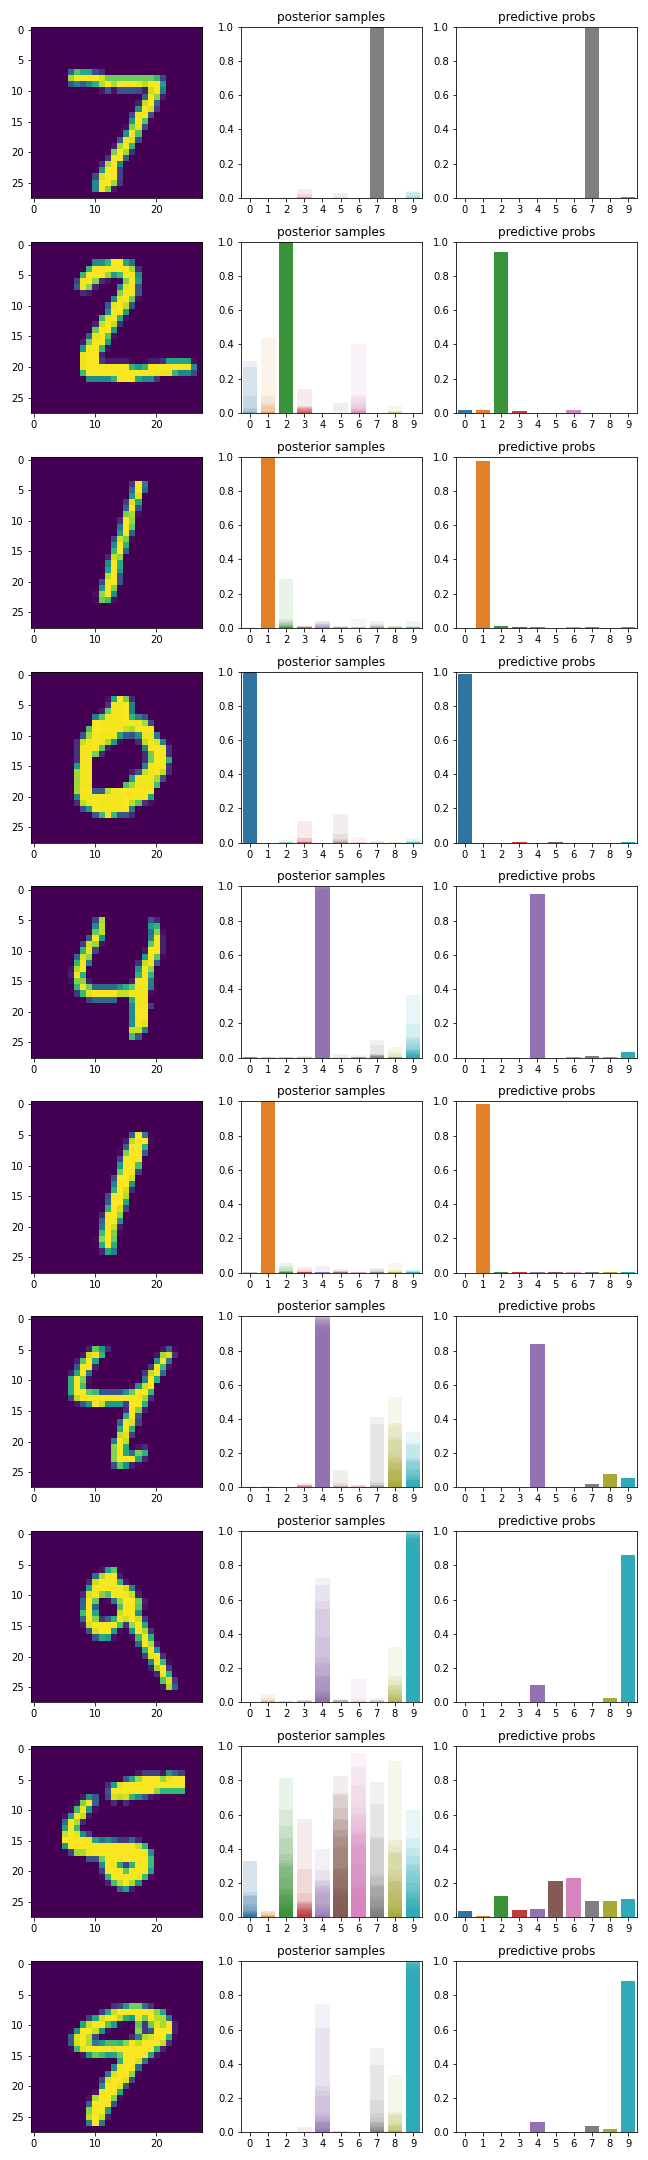

In [ ]:
from IPython.display import Image
Image(filename=f'{FIG_DIR}/probabilty.png') 